In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.spatial.distance import cdist
from scipy.linalg import expm
from scipy.linalg import logm
from scipy.linalg import eig, eigh
from scipy.linalg import null_space
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import expm_multiply
from scipy.optimize import curve_fit
from scipy.integrate import simps 
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

In [2]:
def small_FCC_lattice(a):
    
    x = np.array([1, 0, 0])
    y = np.array([0, 1, 0])
    z = np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
        [1, 1/2, 1/2],
        [1/2, 1, 1/2],
        [1/2, 1/2, 1],
        x, y, z, x+y, x+z, y+z,
        [1, 1, 1],  
        ])
    
    # List positions for second FCC points which lie inside first FCC unit cell
    fcc2_positions = offset + a*np.array([
        [0, 0, 0],  # Corner atom
        [1/2, 1/2, 0],  # Face center (x-y plane)
        [1/2, 0, 1/2],  # Face center (x-z plane)
        [0, 1/2, 1/2],  # Face center (y-z plane)
    ])

    R = []
    S = []
    for pos in fcc_positions:
        R.append(pos)
    for pos in fcc2_positions:
        S.append(pos)

    return np.array(R), np.array(S)

In [2]:
def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

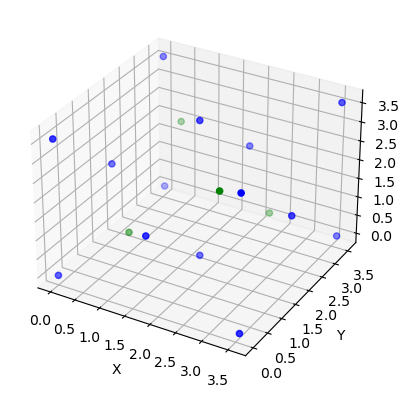

In [160]:
R, S = small_FCC_lattice(3.57)
# R = FCC_lattice(3.57,2)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(R[:,0], R[:,1], R[:,2], color='b', marker='o')
ax.scatter(S[:,0], S[:,1], S[:,2], color='g', marker='o')
# ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [7]:
#Check for duplicates (true means no duplicates)
unique_elements = set(tuple(arr) for arr in R)
print(len(unique_elements) == len(R))

True


In [161]:
#Randomly place 13C and electrons in lattice
R = FCC_lattice(3.57,12)

prob_C = 1.1*1e-2
prob_e = 30*1e-6
specials = sorted(random.sample(range(len(R)),int(len(R)*prob_C) + int(len(R)*prob_e)))
carbons = random.sample(specials, int(len(R)*prob_C))
electrons = [pt for pt in specials if pt not in carbons]

S = np.zeros(R.shape)
T = np.zeros(R.shape)
for pos in carbons:
    S[pos,:] = R[pos,:]
for pos in electrons:
    T[pos,:] = R[pos,:]
    
carbon_pts = [arr for arr in S if not np.array_equal(arr, np.array([0, 0, 0]))]
carbon_pts = np.array(carbon_pts)

e_pts = [arr for arr in T if not np.array_equal(arr, np.array([0, 0, 0]))]
e_pts = np.array(e_pts)

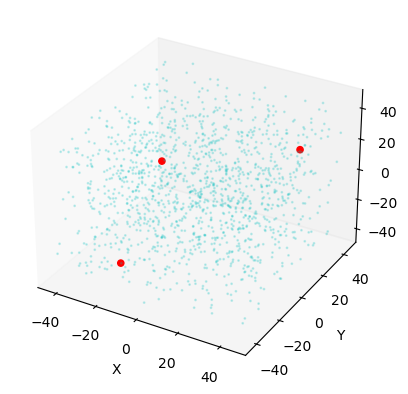

(1375, 3)


In [121]:
a = 3.57
size = 12
prob_C=1.1e-2
prob_e=30e-6
    
# Total number of unit cells
grid_range = np.arange(-size, size + 1)
Ncells = len(grid_range) ** 3
Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

# How many atoms to sample
num_C = int(Natoms * prob_C)
num_e = int(Natoms * prob_e)
total_specials = num_C + num_e

# Sample linear indices (0 to Natoms-1)
indices = np.random.choice(Natoms, total_specials, replace=False)
carbon_indices = np.random.choice(indices, num_C, replace=False)
electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

# Convert linear index to (unit cell index, basis atom index)
unit_index = indices // 8
basis_index = indices % 8

# Map unit index back to (l, m, n) grid coordinates
n_grid = len(grid_range)
L = unit_index // (n_grid ** 2)
M = (unit_index // n_grid) % n_grid
N = unit_index % n_grid
L = L + grid_range[0]
M = M + grid_range[0]
N = N + grid_range[0]

# FCC + offset basis
basis = (a/2)*np.array([
    [0, 0, 0],
    [1, 1, 0],
    [1, 0, 1],
    [0, 1, 1],
    [0.5, 0.5, 0.5],
    [1.5, 1.5, 0.5],
    [1.5, 0.5, 1.5],
    [0.5, 1.5, 1.5],
])

# Construct positions
unit_coords = np.stack([L, M, N], axis=1) * a
special_positions = unit_coords + basis[basis_index]

# Split into carbon and electron positions
carbon_pts = special_positions[np.isin(indices, carbon_indices)]
e_pts = special_positions[np.isin(indices, electron_indices)]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print(carbon_pts.shape)

In [9]:
#mean nearest neighbor carbon distance
all_carbon_distances = cdist(carbon_pts,carbon_pts)
np.fill_diagonal(all_carbon_distances, np.inf)
nn_carbon_distance = np.min(all_carbon_distances, axis=1)
average_nn_carbon = np.mean(nn_carbon_distance)
print(average_nn_carbon, 'angstroms')

4.51742401613025 angstroms


In [10]:
#mean nearest neighbor electron distance
all_electron_distances = cdist(e_pts,e_pts)
np.fill_diagonal(all_electron_distances, np.inf)
nn_electron_distance = np.min(all_electron_distances, axis=1)
average_nn_electron = np.mean(nn_electron_distance)
print(average_nn_electron, 'angstroms')

40.52588648631687 angstroms


In [11]:
#CC dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T
r1 = average_nn_carbon*1e-10
D_CC = 2*np.pi*(mu_0*gamma_C*gamma_C*hbar)/(4*np.pi*(r1**3))
print(D_CC, 'Hz')

82.41166813515322 Hz


In [12]:
#ee dipolar coupling with average nearest neighbor distance
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28.024951e9 #Hz/T
r2 = average_nn_electron*1e-10
D_ee = 2*np.pi*(mu_0*gamma_e*gamma_e*hbar)/(4*np.pi*(r2**3))
print(D_ee*1e-6, 'MHz')

0.7818154639770136 MHz


In [28]:
#wavefunction of NV and P1 both vanish within approximately 2 lattice spacings

In [347]:
# #Calculate distance where dipolar coupling between electron and 13C is equal to D
# D = 250e3
# r3 = ((mu_0*gamma_e*gamma_C*hbar)/(2*(D)))**(1/3)
# print(r3*1e10, 'angstroms')

4.3004494525617805 angstroms


In [122]:
#Calculate spin diffusion barrier radius based on Khutsishvili equation
k_B = 1.38e-23
S = np.tanh((2*np.pi*gamma_e*hbar*9.4)/(2*k_B*100))
r3 = (average_nn_carbon*1e-10)*(S*(gamma_e/gamma_C))**(1/4)
print(r3*1e10, 'angstroms')

16.199446486708446 angstroms


In [15]:
#Carbon-electron coupling at the spin diffusion barrier radius is about 4.5kHz.

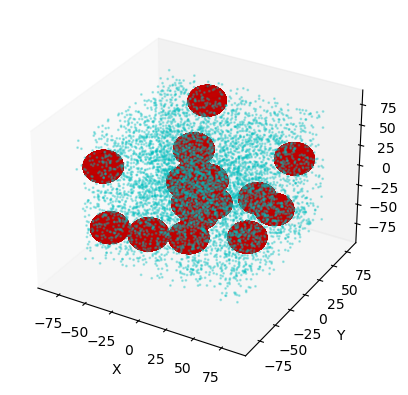

In [16]:
# Define the radius of the spheres
radius = r3*1e10

# Create a meshgrid for the sphere
resolution = 30
u = np.linspace(0, 2 * np.pi, resolution)
v = np.linspace(0, np.pi, resolution)
u, v = np.meshgrid(u, v)

# Parametric equations for the sphere
x_sphere = radius * np.outer(np.cos(u), np.sin(v))
y_sphere = radius * np.outer(np.sin(u), np.sin(v))
z_sphere = radius * np.outer(np.ones(np.size(u)), np.cos(v))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
# Plot spheres around each point
for pos in range(e_pts.shape[0]):
    ax.plot_surface(e_pts[pos][0] + x_sphere, e_pts[pos][1] + y_sphere, e_pts[pos][2] + z_sphere, color='red', alpha=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [123]:
#Calculate the distance between each carbon and the nearest electron and then see if that distance is less than r3
diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
distances = np.linalg.norm(diff, axis=2)
min_distances = np.min(distances, axis=1)

inside_pts = carbon_pts[min_distances < r3*1e10]
outside_pts = carbon_pts[min_distances >= r3*1e10]

In [124]:
N_carbon = carbon_pts.shape[0]
N_e = e_pts.shape[0]
N_bulk = outside_pts.shape[0]
N_core = inside_pts.shape[0]

In [125]:
print((N_core/N_carbon)*100, '% of carbon inside barrier')

5.6000000000000005 % of carbon inside barrier


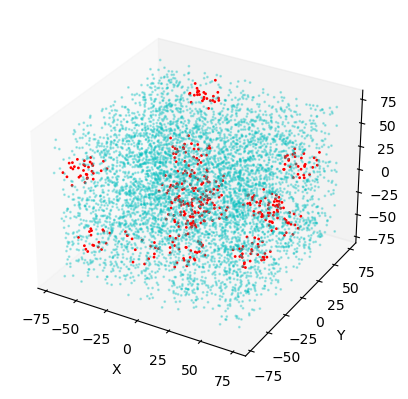

In [20]:
#carbons inside the barrier are plotted in red
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(inside_pts[:,0], inside_pts[:,1], inside_pts[:,2], color='r', marker='o', alpha = 1, s=1)
ax.scatter(outside_pts[:,0], outside_pts[:,1], outside_pts[:,2], color='c', marker='o', alpha = 0.3, s=1)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [126]:
def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

In [38]:
import time
start_time = time.time()

#Calculate R matrix

#Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
#(already similarly done 3 cells above)
diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
distances2 = np.linalg.norm(diff2, axis=2)

R = np.zeros((N_bulk))
rates = np.zeros((N_e))
for carbon in range(N_bulk):
    for e in range(N_e):
        r = distances2[carbon,e]
        angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
        D = 1 - 3*(np.cos(angle))**2 
        C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
        rates[e] = (1/2)*(C**2)*10e-3
    R[carbon] = np.sum(rates)
    rates = np.zeros((N_e))

R = np.diag(R)

end_time = time.time()
print(end_time-start_time)

0.02769637107849121


In [39]:
import time
start_time = time.time()
#Calculate W matrix

#Calculate distances and azimuthal angles between all bulk carbons
#Then calculate diffusion rate matrix W
threshold = 20 #Do not calculate distances and angles for carbons farther apart than threshold (in angstroms)

W = np.zeros((N_bulk, N_bulk))
for pos1 in range(N_bulk):
    for pos2 in range(N_bulk):
        if pos1 != pos2:
            distance = np.linalg.norm(outside_pts[pos1] - outside_pts[pos2])
            if distance < threshold:
                angle = azimuthal_angle(outside_pts[pos1], outside_pts[pos2])
                A = 1 - 3*(np.cos(angle))**2 
                B = ((1/2)*mu_0*gamma_C*gamma_C*hbar*A)/(2*(distance*1e-10)**3)
                W[pos1, pos2] = (1/2)*B**2
                
#Add up entries in each column and subtract from diagonal of W to get conservation of polarization
ratesum = np.sum(W, axis = 0)
W = W - np.diag(ratesum)

end_time = time.time()
print(end_time-start_time)

4.556210041046143


In [127]:
import time
start_time = time.time()

#Calculate W matrix
from scipy.spatial import cKDTree

threshold = 20
tree = cKDTree(outside_pts)
pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

W = np.zeros((N_bulk, N_bulk))
for i, j in pairs:
    diff = outside_pts[i] - outside_pts[j]
    dist = np.linalg.norm(diff)
    unit_vec = diff / dist
    angle = np.arccos(unit_vec[2])

    A = 1 - 3 * (np.cos(angle))**2
    B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
    W[i, j] = 0.5 * B**2
    W[j, i] = 0.5 * B**2  # symmetry

W = W - np.diag(np.sum(W, axis=0))

end_time = time.time()
print(end_time-start_time)

0.22930455207824707


In [128]:
#With periodic boundary conditions

import time
start_time = time.time()

#Calculate W matrix
from scipy.spatial import cKDTree

box_size = 3.57 * (2*12 + 1)

threshold = 20

W_PBC = np.zeros((N_bulk, N_bulk))
for i in range(N_bulk - 1):
    for j in range(i + 1, N_bulk):
        diff = outside_pts[i] - outside_pts[j]
        diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
    #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
    #         print("PBC adjusted a distance!")
        dist = np.linalg.norm(diff)
        if dist > threshold:
                W_PBC[i, j] = 0
                W_PBC[j, i] = 0  # symmetry
        else:    
            unit_vec = diff / dist
            angle = np.arccos(unit_vec[2])

            A = 1 - 3 * (np.cos(angle))**2
            B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
            W_PBC[i, j] = 0.5 * B**2
            W_PBC[j, i] = 0.5 * B**2  # symmetry

W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

end_time = time.time()
print(end_time-start_time)

5.758776903152466


In [120]:
are_equal = np.array_equal(W, W_PBC)
print(are_equal)

False


In [41]:
import time
start_time = time.time()
# M = W
# M = -R
M = -R
t_pts = 100
T = np.linspace(0, 10e-3, t_pts)
alpha_0 = (1/N_bulk)*np.ones(N_bulk)
alpha = np.zeros((N_bulk, t_pts))

evals, evecs = eigh(M)
V_inv = np.linalg.inv(evecs)

# max_exp = 1000
# evals_clipped = np.clip(evals, -max_exp, max_exp)

V_alpha = V_inv @ alpha_0
for t in range(t_pts):
    alpha[:, t] = evecs @ (np.exp(evals * T[t]) * V_alpha)
    
end_time = time.time()
print(end_time-start_time)

0.09795880317687988


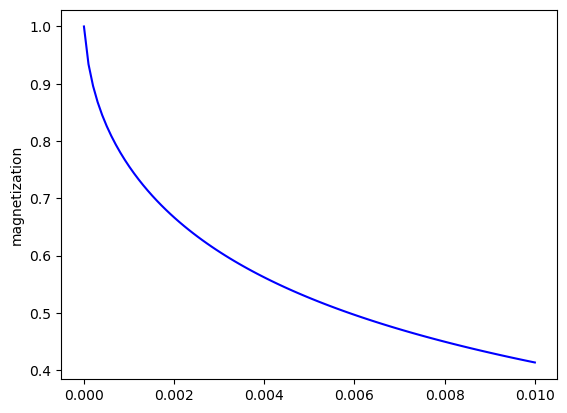

In [42]:
#Plot magnetization as a function of time
P = np.sum(alpha, axis=0)

fig = plt.figure()
plt.plot(T, P, color='b')  
plt.ylabel('magnetization')
plt.show()

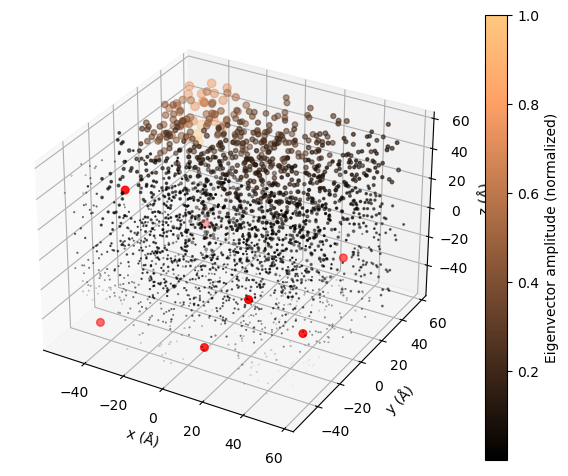

In [108]:
def sample_special_positions(a, size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    total_specials = num_C + num_e

    # Sample linear indices (0 to Natoms-1)
    indices = np.random.choice(Natoms, total_specials, replace=False)
    carbon_indices = np.random.choice(indices, num_C, replace=False)
    electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

    # Convert linear index to (unit cell index, basis atom index)
    unit_index = indices // 8
    basis_index = indices % 8

    # Map unit index back to (l, m, n) grid coordinates
    n_grid = len(grid_range)
    L = unit_index // (n_grid ** 2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid
    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    # FCC + offset basis
    basis = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])

    # Construct positions
    unit_coords = np.stack([L, M, N], axis=1) * a
    special_positions = unit_coords + basis[basis_index]

    # Split into carbon and electron positions
    carbon_pts = special_positions[np.isin(indices, carbon_indices)]
    e_pts = special_positions[np.isin(indices, electron_indices)]

    return carbon_pts, e_pts



def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])



def calculate_M(carbon_pts, e_pts, tau_p, tau_d):
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

    N_carbon = carbon_pts.shape[0]
    N_e = e_pts.shape[0]
    N_bulk = outside_pts.shape[0]
    N_core = inside_pts.shape[0]
    
    #Calculate R matrix

    #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
    #(already similarly done 3 cells above)
    diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances2 = np.linalg.norm(diff2, axis=2)

    R = np.zeros((N_bulk))
    rates = np.zeros((N_e))
    for carbon in range(N_bulk):
        for e in range(N_e):
            r = distances2[carbon,e]
            angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
            D = 1 - 3*(np.cos(angle))**2 
            C = ((1/2)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
            rates[e] = (1/2)*(C**2)*tau_p
        R[carbon] = np.sum(rates)
        rates = np.zeros((N_e))

    R = np.diag(R)
    
    #Calculate W matrix
    from scipy.spatial import cKDTree

    threshold = 20
    tree = cKDTree(outside_pts)
    pairs = tree.query_pairs(r=threshold, output_type='ndarray')  # shape: (num_pairs, 2)

    W = np.zeros((N_bulk, N_bulk))
    for i, j in pairs:
        diff = outside_pts[i] - outside_pts[j]
        dist = np.linalg.norm(diff)
        unit_vec = diff / dist
        angle = np.arccos(unit_vec[2])

        A = 1 - 3 * (np.cos(angle))**2
        B = (0.5 * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
        W[i, j] = 0.5 * B**2 * tau_d
        W[j, i] = 0.5 * B**2 * tau_d# symmetry

    W = W - np.diag(np.sum(W, axis=0))
    
    M = W-R
    return N_bulk, M, outside_pts



size = 15
carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
N_bulk, M, outside_pts = calculate_M(carbon_pts, e_pts, 1.3e-6, 0.007)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(M)  # use eigh since M is symmetric

# fig = plt.figure()
# plt.scatter(range(len(eigvals)), eigvals, color='b')  
# plt.show()

# Get the eigenvector corresponding to the lowest eigenvalue
lowest_mode = eigvecs[:, -1]  # eigenvectors are in columns, sorted for eigh
lowest_eigval = eigvals[-1]

# Normalize (optional)
normalized_mode = np.abs(lowest_mode) / np.max(np.abs(lowest_mode))

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use color map based on value of the eigenvector component
sc = ax.scatter(outside_pts[:, 0], outside_pts[:, 1], outside_pts[:, 2],
                c=normalized_mode, cmap='copper', s=np.abs(normalized_mode)*50)

ax.scatter(e_pts[:, 0], e_pts[:, 1], e_pts[:, 2],
           color='red', s=30, label='Electron traps')

plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# ax.set_title(f"Mode corresponding to lowest eigenvalue: {lowest_eigval:.3e}")
ax.set_xlabel("x (Å)")
ax.set_ylabel("y (Å)")
ax.set_zlabel("z (Å)")
ax.grid = False
plt.tight_layout()
plt.show()


# k = 5  # Number of lowest modes to include

# # Get the first k eigenvectors (columns of eigvecs)
# low_modes = eigvecs[:, :k]

# # Compute participation: sum of squared amplitudes for each site across k modes
# # (This is like a local density of states or participation intensity)
# combined_strength = np.sum(low_modes**2, axis=1)

# # Normalize for visualization
# normalized_strength = combined_strength / np.max(combined_strength)

# # Plot in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot carbon atoms colored by combined mode strength
# sc = ax.scatter(outside_pts[:, 0], outside_pts[:, 1], outside_pts[:, 2],
#                 c=normalized_strength, cmap='winter', s=np.abs(normalized_strength)*50)

# # Plot electron traps
# ax.scatter(e_pts[:, 0], e_pts[:, 1], e_pts[:, 2],
#            color='red', s=30)

# # Colorbar and labels
# plt.colorbar(sc, label='Combined eigenvector strength (normalized)')
# ax.set_title(f"Sum of First {k} Modes")
# ax.set_xlabel("x (Å)")
# ax.set_ylabel("y (Å)")
# ax.set_zlabel("z (Å)")
# ax.grid = False
# plt.tight_layout()
# plt.show()

(64, 100)
168.29905104637146


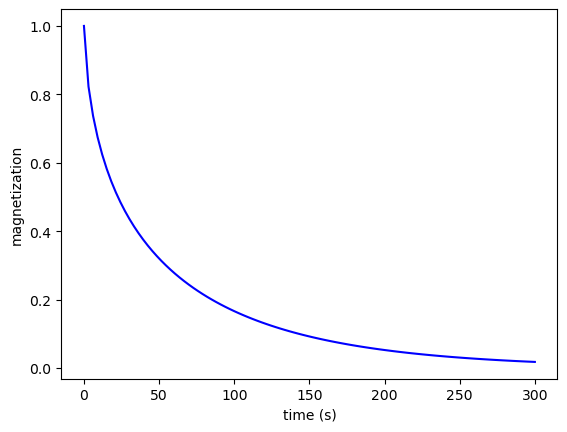

In [19]:
#Run different lattice configurations simultaneously using different CPU cores

from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    
    import numpy as np
    from scipy.linalg import eigh
    import random
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts
   



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)
        
        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
#                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)
            
                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M



    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha
    
    
    tau_p, tau_d = params
    
    size = 12
    T = np.linspace(0,300,100)
    P = np.zeros(len(T))
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
    N_bulk, M = calculate_M(size, carbon_pts, e_pts, tau_p, tau_d)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P


iterations = 64
inputs = [(1.75e-8, 2.5e-5)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,300,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

RMSE product: 0.0023065650432065213


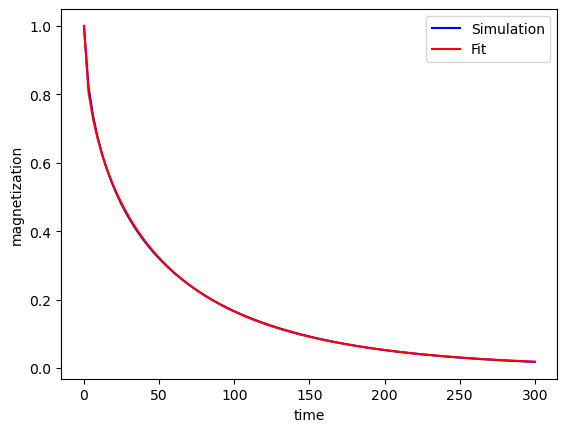

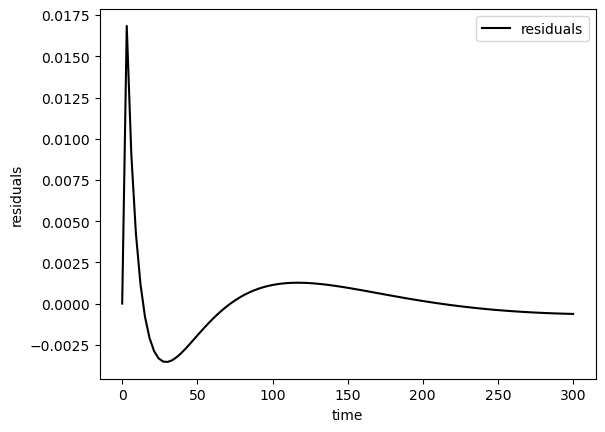

In [37]:
def product_exp(x, a, b):
    return np.exp(-np.sqrt(a*x))*np.exp(-b*x)

def purely_stretched(x, a):
    return np.exp(-np.sqrt(a*x)) 

def monoexp(x, a):
    return np.exp(-a*x)

def KWW(x, a, gamma):
    return np.exp(-(a*x)**gamma)

def sum_monoexp(x, a, b, c, d):
    return c*np.exp(-a*x) + d*np.exp(-b*x)


# Fit the data
popt, pcov = curve_fit(product_exp, T, P_avg, bounds=([0,0] ,[1,1]))

# # popt = optimal values for a, b, c
# print("Fitted parameters:", popt)
# # Optional: Get standard deviation errors
# perr = np.sqrt(np.diag(pcov))
# print("Parameter errors:", perr)

y_fit = product_exp(T, *popt)
residuals = P_avg - y_fit
rmse_product = np.sqrt(np.mean(residuals**2))
print("RMSE product:", rmse_product)

# Plot the data and the fitted curve
fig = plt.figure()
plt.plot(T, P_avg, color='b', label="Simulation")
plt.plot(T, product_exp(T, *popt), color='red', label="Fit")
# plt.semilogy(np.sqrt(T), P_avg, color='b', label="Simulation")
# plt.semilogy(np.sqrt(T), product_exp(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("magnetization")
plt.show()

# print('stretched rate =', popt[0]*1e3, '(1/s x 10^-3)', 'monoexp. rate =', popt[1]*1e3, '(1/s x 10^-3)')

fig = plt.figure()
plt.plot(T, residuals, color='black', label="residuals")
# plt.plot(T, KWW(T, *popt), color='red', label="Fit")
plt.legend()
plt.xlabel("time")
plt.ylabel("residuals")
plt.show()

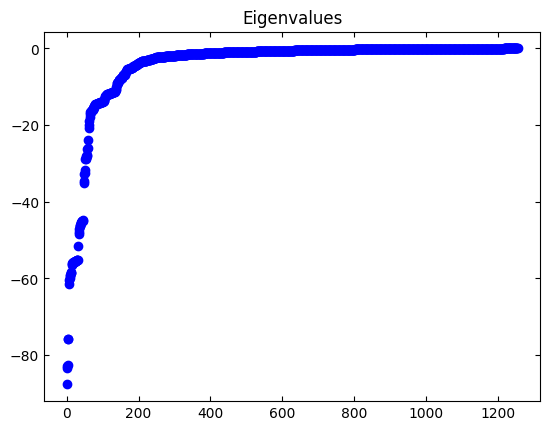

-0.012268739241385896
5.029754638671875


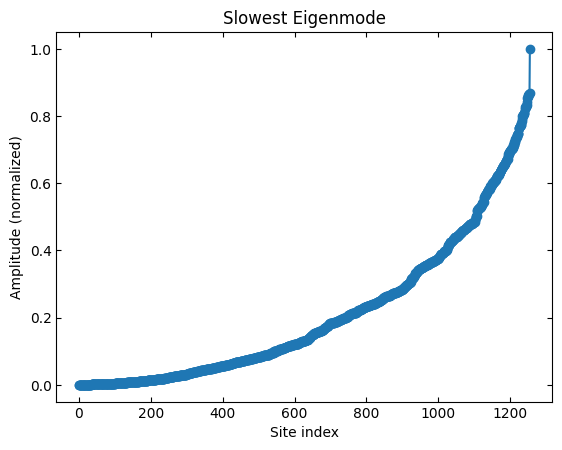

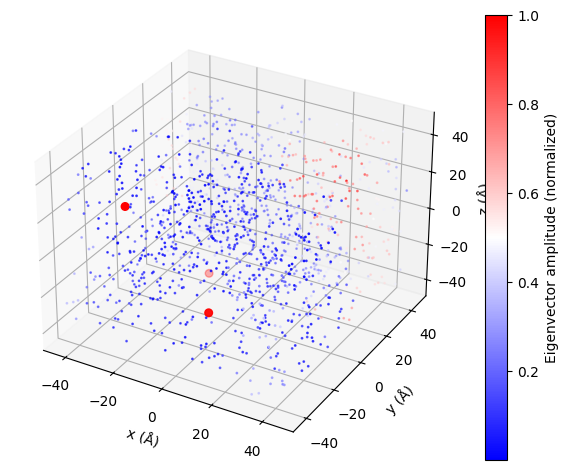

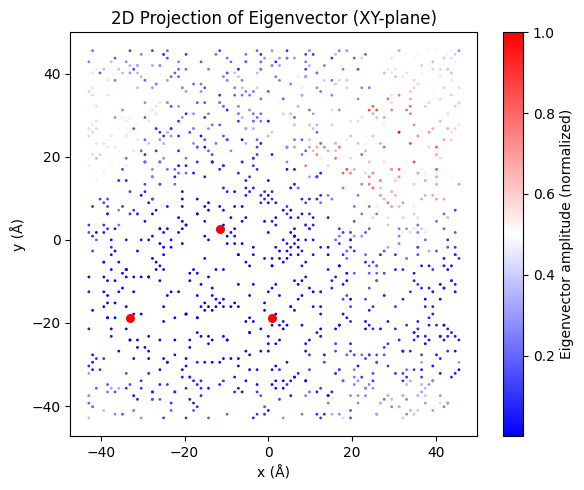

In [144]:
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T

def sample_special_positions(a, size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    total_specials = num_C + num_e

    # Sample linear indices (0 to Natoms-1)
    indices = np.random.choice(Natoms, total_specials, replace=False)
    carbon_indices = np.random.choice(indices, num_C, replace=False)
    electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

    # Convert linear index to (unit cell index, basis atom index)
    unit_index = indices // 8
    basis_index = indices % 8

    # Map unit index back to (l, m, n) grid coordinates
    n_grid = len(grid_range)
    L = unit_index // (n_grid ** 2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid
    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    # FCC + offset basis
    basis = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])

    # Construct positions
    unit_coords = np.stack([L, M, N], axis=1) * a
    special_positions = unit_coords + basis[basis_index]

    # Split into carbon and electron positions
    carbon_pts = special_positions[np.isin(indices, carbon_indices)]
    e_pts = special_positions[np.isin(indices, electron_indices)]

    return carbon_pts, e_pts



def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

r3 = 16*1e-10

def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

    N_carbon = carbon_pts.shape[0]
    N_e = e_pts.shape[0]
    N_bulk = outside_pts.shape[0]
    N_core = inside_pts.shape[0]

    #Calculate R matrix

    #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
    #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

    box_size = 3.57 * (2*size + 1)

    R = np.zeros((N_bulk))
    rates = np.zeros((N_e))
    for carbon in range(N_bulk):
        for e in range(N_e):
#                 r = distances2[carbon,e]
            diff_r = outside_pts[carbon] - e_pts[e]
            diff_r = diff_r - box_size * np.round(diff_r / box_size)
            r = np.linalg.norm(diff_r)

            unit_vec = diff_r / r
            angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
            D = 1 - 3*(np.cos(angle))**2 
            C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
            rates[e] = (1/2)*(C**2)*tau_p
        R[carbon] = np.sum(rates)
        rates = np.zeros((N_e))

    R = np.diag(R)

    #Calculate W matrix
    threshold = 20

    W_PBC = np.zeros((N_bulk, N_bulk))
    for i in range(N_bulk - 1):
        for j in range(i + 1, N_bulk):
            diff = outside_pts[i] - outside_pts[j]
            diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
        #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
        #         print("PBC adjusted a distance!")
            dist = np.linalg.norm(diff)
            if dist > threshold:
                    W_PBC[i, j] = 0
                    W_PBC[j, i] = 0  # symmetry
            else:    
                unit_vec = diff / dist
                angle = np.arccos(unit_vec[2])

                A = 1 - 3 * (np.cos(angle))**2
                B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                W_PBC[i, j] = 0.5 * B**2 * tau_d
                W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

    W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

    M = W_PBC - R
    
    return N_bulk, M, outside_pts


import time
start_time = time.time()

size = 12
carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)

# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(M)  # use eigh since M is symmetric

fig = plt.figure()
plt.scatter(range(len(eigvals)), eigvals, color='b')  
plt.title("Eigenvalues")
# plt.xlabel("Site index")
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(direction='in')
plt.show()

# Get the eigenvector corresponding to the lowest eigenvalue
lowest_mode = eigvecs[:, -1]  # eigenvectors are in columns, sorted for eigh
lowest_eigval = eigvals[-1]

# Normalize (optional)
normalized_mode = np.abs(lowest_mode) / np.max(np.abs(lowest_mode))

print(lowest_eigval)

end_time = time.time()
print(end_time-start_time)

plt.figure()
plt.plot(np.sort(normalized_mode), marker='o')
plt.title("Slowest Eigenmode")
plt.xlabel("Site index")
plt.ylabel("Amplitude (normalized)")
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(direction='in')
# plt.grid(True)
plt.show()

# Plot in 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Use color map based on value of the eigenvector component
sc = ax.scatter(outside_pts[:, 0], outside_pts[:, 1], outside_pts[:, 2],
                c=normalized_mode, cmap='bwr', s=1)

ax.scatter(e_pts[:, 0], e_pts[:, 1], e_pts[:, 2],
           color='red', s=30, label='Electron traps')

plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# ax.set_title(f"Mode corresponding to lowest eigenvalue: {lowest_eigval:.3e}")
ax.set_xlabel("x (Å)")
ax.set_ylabel("y (Å)")
ax.set_zlabel("z (Å)")
ax.grid = False
plt.tight_layout()
plt.show()


# Plot 2D projection on the XY-plane
plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_mode, cmap='bwr', s=1, label='13C spins')

# Plot electron trap positions in red
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='red', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("2D Projection of Eigenvector (XY-plane)")
plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# plt.legend()
plt.tight_layout()
plt.show()

# k = 5  # Number of lowest modes to include

# # Get the first k eigenvectors (columns of eigvecs)
# low_modes = eigvecs[:, :k]

# # Compute participation: sum of squared amplitudes for each site across k modes
# # (This is like a local density of states or participation intensity)
# combined_strength = np.sum(low_modes**2, axis=1)

# # Normalize for visualization
# normalized_strength = combined_strength / np.max(combined_strength)

# # Plot in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Plot carbon atoms colored by combined mode strength
# sc = ax.scatter(outside_pts[:, 0], outside_pts[:, 1], outside_pts[:, 2],
#                 c=normalized_strength, cmap='winter', s=np.abs(normalized_strength)*50)

# # Plot electron traps
# ax.scatter(e_pts[:, 0], e_pts[:, 1], e_pts[:, 2],
#            color='red', s=30)

# # Colorbar and labels
# plt.colorbar(sc, label='Combined eigenvector strength (normalized)')
# ax.set_title(f"Sum of First {k} Modes")
# ax.set_xlabel("x (Å)")
# ax.set_ylabel("y (Å)")
# ax.set_zlabel("z (Å)")
# ax.grid = False
# plt.tight_layout()
# plt.show()

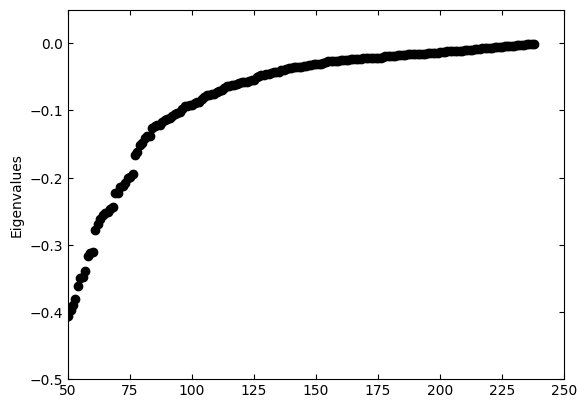

In [119]:
fig = plt.figure()
plt.scatter(range(len(eigvals)), eigvals, color='black')  
plt.ylabel("Eigenvalues")
# plt.xlabel("Site index")
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(direction='in')
# plt.xlim(50, 250)
# plt.ylim(-0.5,0.05)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\0.2%Eigenvalues_zoomed.eps", format='eps', dpi=300)

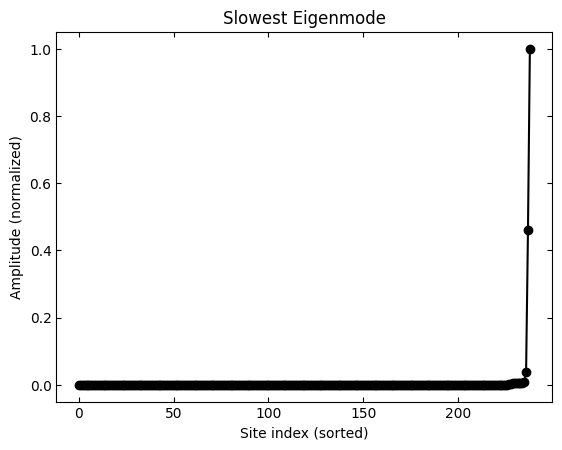

In [120]:
fig = plt.figure()
plt.plot(np.sort(normalized_mode), marker='o', color='black')
plt.title("Slowest Eigenmode")
plt.xlabel("Site index (sorted)")
plt.ylabel("Amplitude (normalized)")
plt.tick_params(which='both', direction='in', top=True, right=True)
plt.tick_params(direction='in')
# plt.grid(True)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\0.2%Eigenvector_Amps.eps", format='eps', dpi=300)

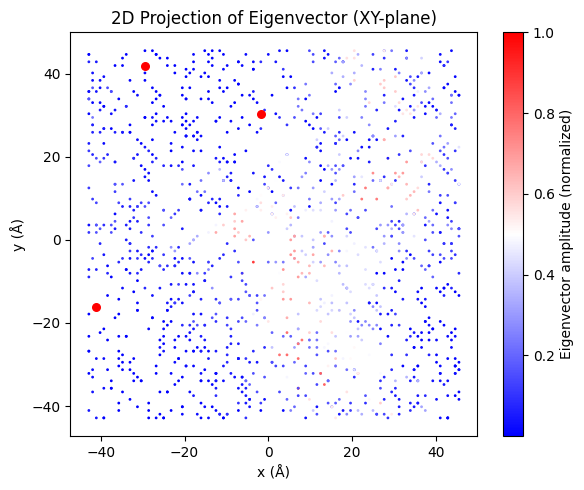

In [46]:
# lowest_mode = eigvecs[:, -1]
# normalized_mode = np.abs(lowest_mode) / np.max(np.abs(lowest_mode))

num_modes = 5
lowest_modes = eigvecs[:, -num_modes:]
combined_amplitude = np.sum(np.abs(lowest_modes), axis=1)
normalized_mode = combined_amplitude / np.max(combined_amplitude)

# Plot 2D projection on the XY-plane
plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_mode, cmap='bwr', s=1, label='13C spins')

# Plot electron trap positions in red
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='red', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("2D Projection of Eigenvector (XY-plane)")
plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# plt.legend()
plt.tight_layout()
plt.show()

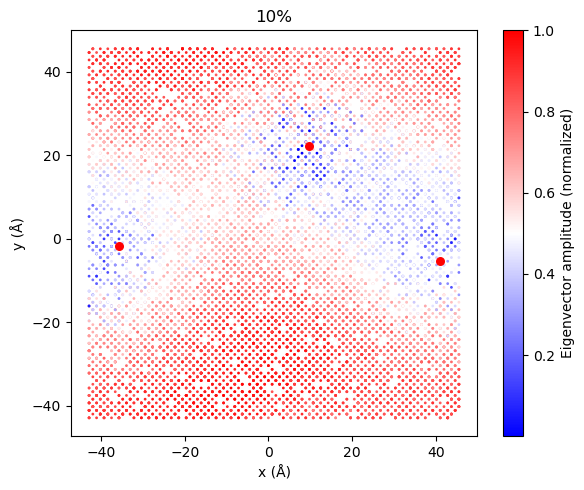

In [97]:
# Plot 2D projection on the XY-plane
fig = plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_mode, cmap='bwr', s=1, label='13C spins')

# Plot electron trap positions in red
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='red', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("10%")
plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\10%Eigenvector.eps", format='eps', dpi=300)

30161.805207252502


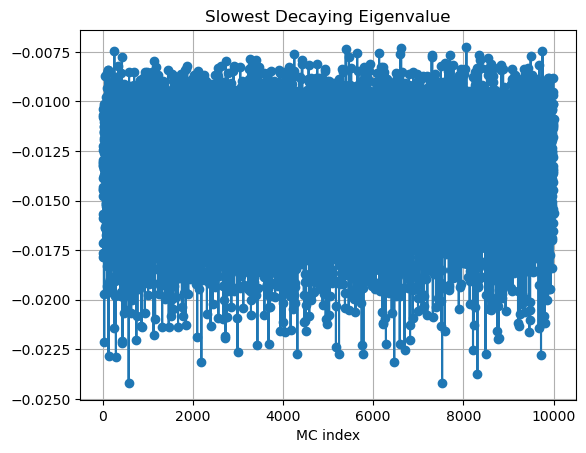

In [296]:
from pathos.multiprocessing import ProcessingPool as Pool

import time
start_time = time.time()

def run_simulation(params):
    
    import numpy as np
    import random
    from scipy.spatial.distance import cdist
    from scipy.linalg import expm
    from scipy.linalg import logm
    from scipy.linalg import eig, eigh
    from scipy.linalg import null_space
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import expm_multiply
    from scipy.integrate import simps 
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
    #         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    #         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
    #                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)

                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
    #                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M, outside_pts

    
    size = 12
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
    N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)
    eigvals = np.linalg.eigvalsh(M)
    lowest_eigval = eigvals[-1]
    return lowest_eigval


iterations = 10000
inputs = [(1)] * iterations

pool = Pool()
results = pool.map(run_simulation, inputs)    
    
end_time = time.time()
print(end_time-start_time)
    
lowest_eigvals = np.array(results)

plt.figure()
plt.plot(lowest_eigvals, marker='o')
plt.title("Slowest Decaying Eigenvalue")
plt.xlabel("MC index")
plt.grid(True)
plt.show()

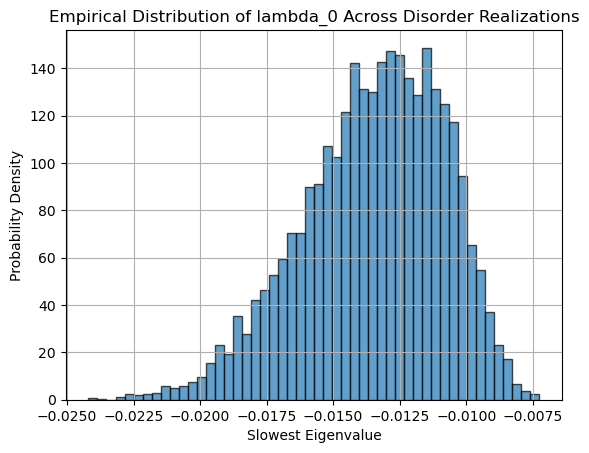

In [297]:
plt.hist(lowest_eigvals, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.xlabel('Slowest Eigenvalue')
plt.ylabel('Probability Density')
plt.title('Empirical Distribution of lambda_0 Across Disorder Realizations')
plt.grid(True)
plt.show()

# from statsmodels.distributions.empirical_distribution import ECDF

# ecdf = ECDF(lowest_eigvals)
# plt.plot(ecdf.x, ecdf.y)
# plt.xlabel('lambda_0')
# plt.ylabel('Cumulative Probability')
# plt.title('Empirical CDF of lambda_0')
# plt.grid(True)
# plt.show()

5.828988075256348


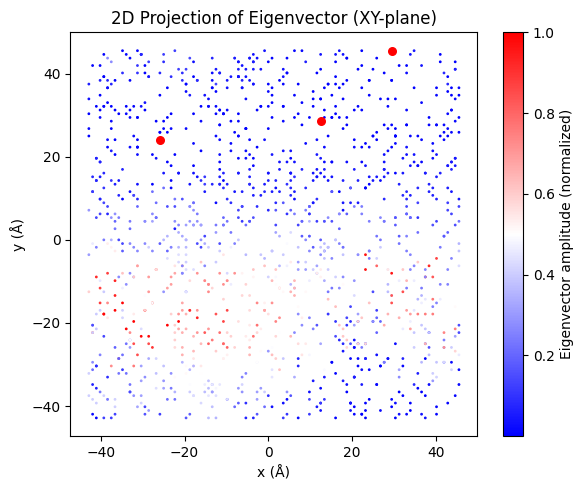

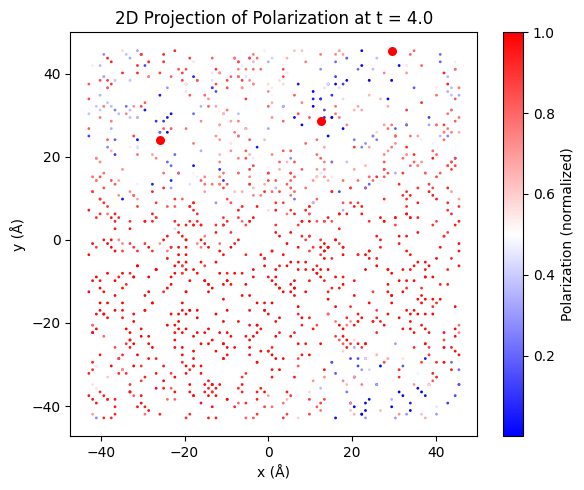

In [31]:
mu_0 = 1.256e-6 #NA^-2
hbar = 1.055e-34 #Js
gamma_C = 10.7084e6 #Hz/T
gamma_e = 28024.951e6 #Hz/T

def sample_special_positions(a, size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    total_specials = num_C + num_e

    # Sample linear indices (0 to Natoms-1)
    indices = np.random.choice(Natoms, total_specials, replace=False)
    carbon_indices = np.random.choice(indices, num_C, replace=False)
    electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

    # Convert linear index to (unit cell index, basis atom index)
    unit_index = indices // 8
    basis_index = indices % 8

    # Map unit index back to (l, m, n) grid coordinates
    n_grid = len(grid_range)
    L = unit_index // (n_grid ** 2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid
    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    # FCC + offset basis
    basis = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])

    # Construct positions
    unit_coords = np.stack([L, M, N], axis=1) * a
    special_positions = unit_coords + basis[basis_index]

    # Split into carbon and electron positions
    carbon_pts = special_positions[np.isin(indices, carbon_indices)]
    e_pts = special_positions[np.isin(indices, electron_indices)]

    return carbon_pts, e_pts



def azimuthal_angle(p1, p2):
    diff = p1 - p2
    norm_diff = diff/np.linalg.norm(diff)
    return np.arccos(norm_diff[2])

r3 = 16*1e-10

def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
    diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    distances = np.linalg.norm(diff, axis=2)
    min_distances = np.min(distances, axis=1)

    inside_pts = carbon_pts[min_distances < r3*1e10]
    outside_pts = carbon_pts[min_distances >= r3*1e10]

    N_carbon = carbon_pts.shape[0]
    N_e = e_pts.shape[0]
    N_bulk = outside_pts.shape[0]
    N_core = inside_pts.shape[0]

    #Calculate R matrix

    #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
    #(already similarly done 3 cells above)
#         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
#         distances2 = np.linalg.norm(diff2, axis=2)

    box_size = 3.57 * (2*size + 1)

    R = np.zeros((N_bulk))
    rates = np.zeros((N_e))
    for carbon in range(N_bulk):
        for e in range(N_e):
#                 r = distances2[carbon,e]
            diff_r = outside_pts[carbon] - e_pts[e]
            diff_r = diff_r - box_size * np.round(diff_r / box_size)
            r = np.linalg.norm(diff_r)

            unit_vec = diff_r / r
            angle = np.arccos(unit_vec[2])
#                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
            D = 1 - 3*(np.cos(angle))**2 
            C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
            rates[e] = (1/2)*(C**2)*tau_p
        R[carbon] = np.sum(rates)
        rates = np.zeros((N_e))

    R = np.diag(R)

    #Calculate W matrix
    threshold = 20

    W_PBC = np.zeros((N_bulk, N_bulk))
    for i in range(N_bulk - 1):
        for j in range(i + 1, N_bulk):
            diff = outside_pts[i] - outside_pts[j]
            diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
        #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
        #         print("PBC adjusted a distance!")
            dist = np.linalg.norm(diff)
            if dist > threshold:
                    W_PBC[i, j] = 0
                    W_PBC[j, i] = 0  # symmetry
            else:    
                unit_vec = diff / dist
                angle = np.arccos(unit_vec[2])

                A = 1 - 3 * (np.cos(angle))**2
                B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                W_PBC[i, j] = 0.5 * B**2 * tau_d
                W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

    W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

    M = W_PBC - R
    return N_bulk, M, outside_pts

def solve_ode(N_bulk, time, alpha_0, M):
    t_pts = len(time)
    alpha = np.zeros((N_bulk, t_pts))

    evals, evecs = eigh(M)
    V_inv = np.linalg.inv(evecs)

    # max_exp = 1000
    # evals_clipped = np.clip(evals, -max_exp, max_exp)

    V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
    for t in range(t_pts):
        alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

    return alpha


import time
start_time = time.time()

size = 12
T = np.linspace(0,200,100)
carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)
alpha_0 = (1/N_bulk)*np.ones(N_bulk)
alpha = solve_ode(N_bulk, T, alpha_0, M)
P = np.sum(alpha, axis=0)
    
# Compute eigenvalues and eigenvectors
eigvals, eigvecs = np.linalg.eigh(M)  # use eigh since M is symmetric

# fig = plt.figure()
# plt.scatter(range(len(eigvals)), eigvals, color='b')  
# plt.title("Eigenvalues")
# # plt.xlabel("Site index")
# plt.tick_params(which='both', direction='in', top=True, right=True)
# plt.tick_params(direction='in')
# plt.show()

# Get the eigenvector corresponding to the lowest eigenvalue
lowest_mode = eigvecs[:, -1]  # eigenvectors are in columns, sorted for eigh
lowest_eigval = eigvals[-1]

# Normalize (optional)
normalized_mode = np.abs(lowest_mode) / np.max(np.abs(lowest_mode))

end_time = time.time()
print(end_time-start_time)

# plt.figure()
# plt.plot(np.sort(normalized_mode), marker='o')
# plt.title("Slowest Eigenmode")
# plt.xlabel("Site index")
# plt.ylabel("Amplitude (normalized)")
# plt.tick_params(which='both', direction='in', top=True, right=True)
# plt.tick_params(direction='in')
# # plt.grid(True)
# plt.show()

# # Plot in 3D
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Use color map based on value of the eigenvector component
# sc = ax.scatter(outside_pts[:, 0], outside_pts[:, 1], outside_pts[:, 2],
#                 c=normalized_mode, cmap='bwr', s=1)

# ax.scatter(e_pts[:, 0], e_pts[:, 1], e_pts[:, 2],
#            color='red', s=30, label='Electron traps')

# plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# # ax.set_title(f"Mode corresponding to lowest eigenvalue: {lowest_eigval:.3e}")
# ax.set_xlabel("x (Å)")
# ax.set_ylabel("y (Å)")
# ax.set_zlabel("z (Å)")
# ax.grid = False
# plt.tight_layout()
# plt.show()


# Plot 2D projection on the XY-plane
plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_mode, cmap='bwr', s=1, label='13C spins')

# Plot electron trap positions in red
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='red', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("2D Projection of Eigenvector (XY-plane)")
plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# plt.legend()
plt.tight_layout()
plt.show()



t_index = 2
polarization_snapshot = alpha[:, t_index]

normalized_polarization = polarization_snapshot / np.max(np.abs(polarization_snapshot))

plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_polarization, cmap='bwr', s=1, label='13C spins')

plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='red', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title(f"2D Projection of Polarization at t = {T[t_index]:.1f}")
plt.colorbar(sc, label="Polarization (normalized)")
plt.tight_layout()
plt.show()

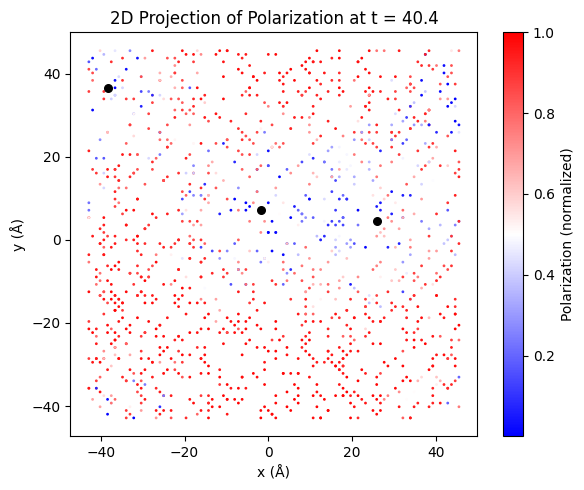

In [30]:
t_index = 2
polarization_snapshot = alpha[:, t_index]

normalized_polarization = polarization_snapshot / np.max(np.abs(polarization_snapshot))

fig = plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_polarization, cmap='bwr', s=1, label='13C spins')

plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='black', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title(f"2D Projection of Polarization at t = {T[t_index]:.1f}")
plt.colorbar(sc, label="Polarization (normalized)")
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\1.1%Polarization_t=50.eps", format='eps', dpi=300)

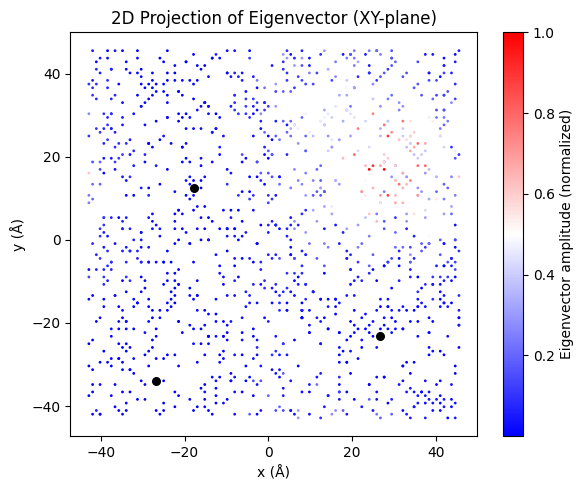

In [184]:
fig = plt.figure(figsize=(6, 5))
sc = plt.scatter(outside_pts[:, 0], outside_pts[:, 1],
                 c=normalized_mode, cmap='bwr', s=1, label='13C spins')

plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='black', s=30, label='Electron traps')

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("2D Projection of Eigenvector (XY-plane)")
plt.colorbar(sc, label="Eigenvector amplitude (normalized)")
# plt.legend()
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\1.1%Eigenvector_supplement.eps", format='eps', dpi=300)

Text(0, 0.5, 'Polarization')

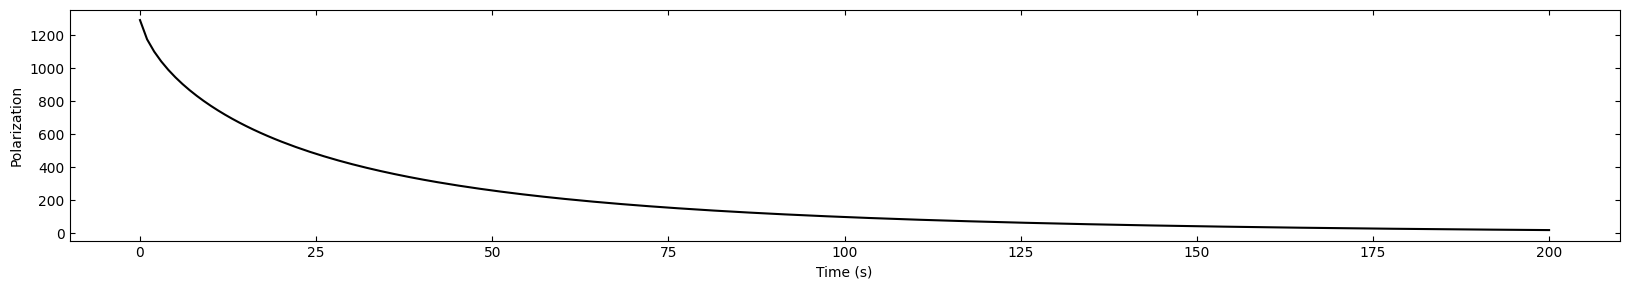

In [105]:
fig = plt.figure(figsize=(8, 3))
plt.plot(T, P, color='black')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\EigenvectorPolarizationVsTime.eps", format='eps', dpi=300)

In [124]:
from tqdm import tqdm
from scipy.stats import binned_statistic_2d

size = 12
box_size = 3.57 * (2*size + 1)
T = np.linspace(0,200,200)

nbins = 100
xedges = np.linspace(-box_size/2, box_size/2, nbins + 1)
yedges = np.linspace(-box_size/2, box_size/2, nbins + 1)

eigen_amp_sum = np.zeros((nbins, nbins))
counts = np.zeros((nbins, nbins))

polarization_sum_init = np.zeros((nbins, nbins))
polarization_counts_init = np.zeros((nbins, nbins))

polarization_sum_final = np.zeros((nbins, nbins))
polarization_counts_final = np.zeros((nbins, nbins))

e_pts = np.array([
    [26.775, -23.205,  42.84],
    [-26.775, -33.915, -14.28],
    [-17.85,   12.495,  30.345]
])

n_averages = 100
P_avg = np.zeros((n_averages, len(T)))

for i in tqdm(range(n_averages)):
    
    carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
    N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)
    alpha_0 = np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    P_avg[i,:] = P

    eigvals, eigvecs = np.linalg.eigh(M)  
    lowest_mode = eigvecs[:, -1]
    normalized_mode = np.abs(lowest_mode) / np.max(np.abs(lowest_mode))
    
    H, _, _, binnumber = binned_statistic_2d(
        outside_pts[:, 0],  # x-coordinates of spins
        outside_pts[:, 1],  # y-coordinates of spins
        values=normalized_mode,  # eigenvector amplitude for each spin
        statistic='sum',  # compute sum of amplitudes in each bin
        bins=[xedges, yedges]  # 2D grid bins in x and y
    )
    
    
    C, _, _, _ = binned_statistic_2d(
        outside_pts[:, 0],
        outside_pts[:, 1],
        values=None,
        statistic='count', # count number of spins in each bin
        bins=[xedges, yedges]
    )
    
    eigen_amp_sum += np.nan_to_num(H)
    counts += np.nan_to_num(C)
    
    
    t_index_init = 3
    alpha_t_init = alpha[:, t_index_init]  # polarization at final time

    P_H_init, _, _, _ = binned_statistic_2d(
        outside_pts[:, 0],
        outside_pts[:, 1],
        values=alpha_t_init,
        statistic='sum',
        bins=[xedges, yedges]
    )

    P_C_init, _, _, _ = binned_statistic_2d(
        outside_pts[:, 0],
        outside_pts[:, 1],
        values=None,
        statistic='count',
        bins=[xedges, yedges]
    )

    polarization_sum_init += np.nan_to_num(P_H_init)
    polarization_counts_init += np.nan_to_num(P_C_init)
    
    t_index_final = -1
    alpha_t_final = alpha[:, t_index_final]  # polarization at final time

    P_H_final, _, _, _ = binned_statistic_2d(
        outside_pts[:, 0],
        outside_pts[:, 1],
        values=alpha_t_final,
        statistic='sum',
        bins=[xedges, yedges]
    )

    P_C_final, _, _, _ = binned_statistic_2d(
        outside_pts[:, 0],
        outside_pts[:, 1],
        values=None,
        statistic='count',
        bins=[xedges, yedges]
    )

    polarization_sum_final += np.nan_to_num(P_H_final)
    polarization_counts_final += np.nan_to_num(P_C_final)

P_avg = np.mean(P_avg, axis=0) / N_bulk
  
# avg_amp = np.divide(eigen_amp_sum, counts, out=np.zeros_like(eigen_amp_sum), where=counts > 0)

# plt.figure(figsize=(6, 5))
# plt.scatter(e_pts[:, 0], e_pts[:, 1],
#             color='black', s=30, label='Electron traps')

# plt.imshow(
#     avg_amp.T,
#     origin='lower',
#     extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
#     cmap='bwr',
#     aspect='equal'
# )
# plt.colorbar(label='Avg. eigenvector amplitude (normalized)')
# plt.xlabel("x (Å)")
# plt.ylabel("y (Å)")
# plt.title("Averaged 2D Projection of Slowest Eigenmode (XY-plane)")
# plt.tight_layout()
# plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:50<00:00,  5.90s/it]


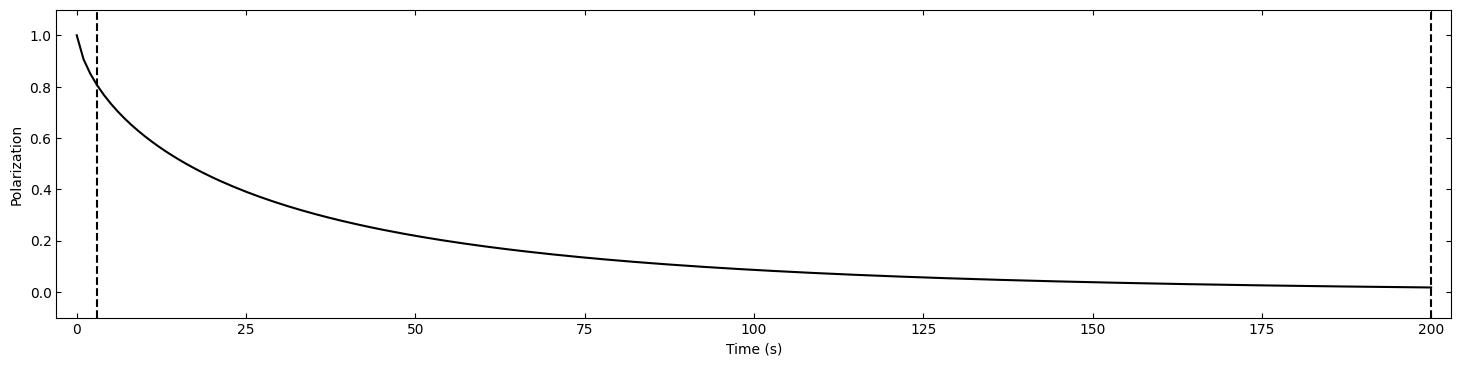

In [126]:
fig = plt.figure(figsize=(18, 4))
plt.plot(T, P_avg, color='black')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.axvline(x=3, color='black', linestyle='--')
plt.axvline(x=200, color='black', linestyle='--')
plt.xlabel("Time (s)")
plt.ylabel("Polarization")
plt.xlim(-3, 203)
plt.ylim(-0.1, 1.1)
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\EigenvectorPolarizationVsTime_v2.eps", format='eps', dpi=300)

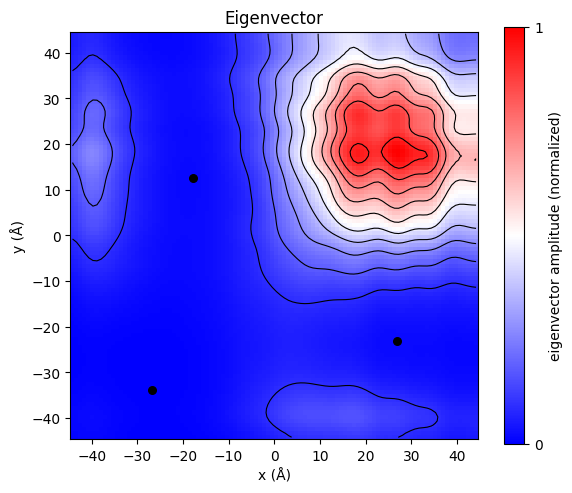

In [128]:
from scipy.ndimage import gaussian_filter

avg_amp = np.divide(eigen_amp_sum, counts, out=np.zeros_like(eigen_amp_sum), where=counts > 0)
avg_amp_smooth = gaussian_filter(avg_amp, sigma=3)

fig = plt.figure(figsize=(6, 5))
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='black', s=30, label='Electron traps')

im = plt.imshow(
    avg_amp_smooth.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='bwr',
    aspect='equal'
)

#Add contours
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

contours = plt.contour(
    xcenters,
    ycenters,
    avg_amp_smooth.T,
    levels=10,
    colors='k',
    linewidths=0.8
)
# plt.clabel(contours, inline=True, fontsize=8)

# Create colorbar with fixed tick range (0 to 1) regardless of data range
cbar = plt.colorbar(im)
cbar.set_label('eigenvector amplitude (normalized)')
cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
cbar.set_ticklabels(['0', '1'])

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Eigenvector")
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\AveragedEigenvectorHeatmapV2.eps", format='eps', dpi=300)

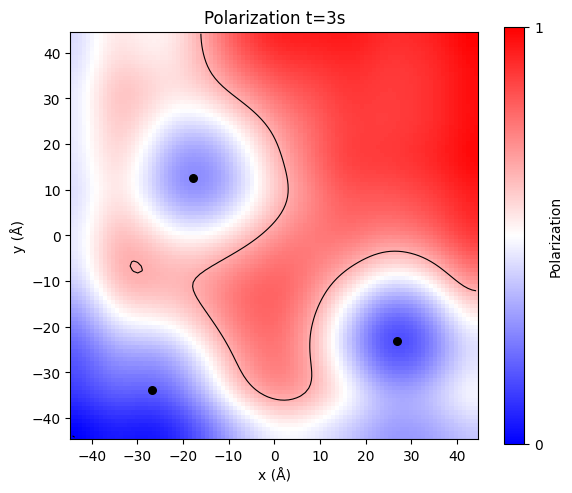

In [400]:
size = 12
box_size = 3.57 * (2*size + 1)
T = np.linspace(0,200,200)
e_pts = np.array([
    [26.775, -23.205,  42.84],
    [-26.775, -33.915, -14.28],
    [-17.85,   12.495,  30.345]
])

from scipy.ndimage import gaussian_filter

avg_polarization_init = np.divide(
    polarization_sum_init,
    polarization_counts_init,
    out=np.zeros_like(polarization_sum_init),
    where=polarization_counts_init > 0
)
avg_polarization_init_smooth = gaussian_filter(avg_polarization_init, sigma=7)

fig = plt.figure(figsize=(6, 5))
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='black', s=30, label='Electron traps')

im = plt.imshow(
    avg_polarization_init_smooth.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='bwr',
    aspect='equal'
)

#Add contours
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

contours = plt.contour(
    xcenters,
    ycenters,
    avg_polarization_init_smooth.T,
    levels=1,
    colors='k',
    linewidths=0.8
)
# plt.clabel(contours, inline=True, fontsize=8)

# Create colorbar with fixed tick range (0 to 1) regardless of data range
cbar = plt.colorbar(im)
cbar.set_label('Polarization')
cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
cbar.set_ticklabels(['0', '1'])

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Polarization t=3s")
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\AveragedPolarizationt=3sHeatmap.eps", format='eps', dpi=300)

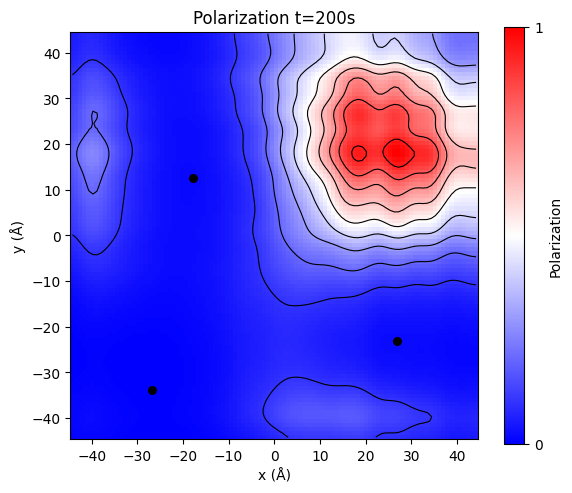

In [132]:
from scipy.ndimage import gaussian_filter

avg_polarization_final = np.divide(
    polarization_sum_final,
    polarization_counts_final,
    out=np.zeros_like(polarization_sum_final),
    where=polarization_counts_final > 0
)
avg_polarization_final_smooth = gaussian_filter(avg_polarization_final, sigma=3)

fig = plt.figure(figsize=(6, 5))
plt.scatter(e_pts[:, 0], e_pts[:, 1],
            color='black', s=30, label='Electron traps')

im = plt.imshow(
    avg_polarization_final_smooth.T,
    origin='lower',
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    cmap='bwr',
    aspect='equal'
)

#Add contours
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2

contours = plt.contour(
    xcenters,
    ycenters,
    avg_polarization_final_smooth.T,
    levels=10,
    colors='k',
    linewidths=0.8
)
# plt.clabel(contours, inline=True, fontsize=8)

# Create colorbar with fixed tick range (0 to 1) regardless of data range
cbar = plt.colorbar(im)
cbar.set_label('Polarization')
cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
cbar.set_ticklabels(['0', '1'])

plt.xlabel("x (Å)")
plt.ylabel("y (Å)")
plt.title("Polarization t=200s")
plt.tight_layout()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\AveragedPolarizationt=200Heatmap.eps", format='eps', dpi=300)

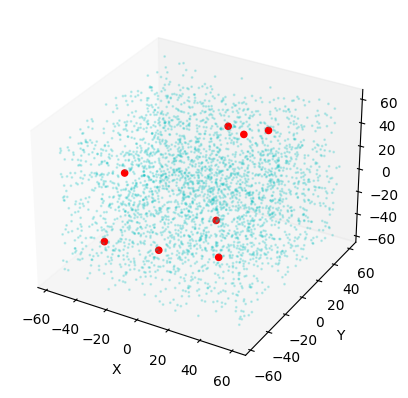

8


In [402]:
def sample_special_positions(a, size, prob_C, prob_e):
    # Total number of unit cells
    grid_range = np.arange(-size, size + 1)
    Ncells = len(grid_range) ** 3
    Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

    # How many atoms to sample
    num_C = int(Natoms * prob_C)
    num_e = int(Natoms * prob_e)
    total_specials = num_C + num_e

    # Sample linear indices (0 to Natoms-1)
    indices = np.random.choice(Natoms, total_specials, replace=False)
    carbon_indices = np.random.choice(indices, num_C, replace=False)
    electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

    # Convert linear index to (unit cell index, basis atom index)
    unit_index = indices // 8
    basis_index = indices % 8

    # Map unit index back to (l, m, n) grid coordinates
    n_grid = len(grid_range)
    L = unit_index // (n_grid ** 2)
    M = (unit_index // n_grid) % n_grid
    N = unit_index % n_grid
    L = L + grid_range[0]
    M = M + grid_range[0]
    N = N + grid_range[0]

    # FCC + offset basis
    basis = (a/2)*np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])

    # Construct positions
    unit_coords = np.stack([L, M, N], axis=1) * a
    special_positions = unit_coords + basis[basis_index]

    # Split into carbon and electron positions
    carbon_pts = special_positions[np.isin(indices, carbon_indices)]
    e_pts = special_positions[np.isin(indices, electron_indices)]

    return carbon_pts, e_pts

a = 3.57
size = 16
prob_C = 1.1e-2
prob_e = 30e-6
carbon_pts, e_pts = sample_special_positions(a, size, prob_C, prob_e)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print(len(e_pts))

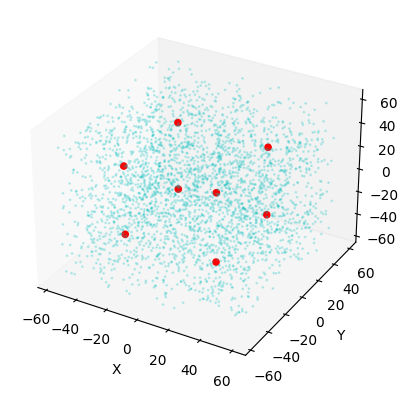

box_size =  117.80999999999999
e_pts =  [[-29.4525 -29.4525 -29.4525]
 [-29.4525 -29.4525  29.4525]
 [-29.4525  29.4525 -29.4525]
 [-29.4525  29.4525  29.4525]
 [ 29.4525 -29.4525 -29.4525]
 [ 29.4525 -29.4525  29.4525]
 [ 29.4525  29.4525 -29.4525]
 [ 29.4525  29.4525  29.4525]]


In [254]:
from scipy.spatial import cKDTree
import math

def FCC_lattice(a,size):

    x = a*np.array([1, 0, 0])
    y = a*np.array([0, 1, 0])
    z = a*np.array([0, 0, 1])

    offset = a*np.array([1/4, 1/4, 1/4]) #offset vector for second FCC lattice

    # List of positions in a single unit cell for FCC structure
    fcc_positions = (a/2)*np.array([
        [0, 0, 0],  # Corner atom
        [1, 1, 0],  # Face center (x-y plane)
        [1, 0, 1],  # Face center (x-z plane)
        [0, 1, 1],  # Face center (y-z plane)
        ])

    R = []
    for l in range(-size, size+1):
        for m in range(-size, size+1):
            for n in range(-size, size+1):
                for pos in fcc_positions:
                    R.append(l*x + m*y + n*z + pos)
                    R.append(l*x + m*y + n*z + pos + offset)

    return np.array(R)

# def place_electrons_uniformly(R, num_electrons, size):

#     box_length = 3.57 * (2*size + 1)

#     n_per_axis = int(np.ceil(num_electrons ** (1/3))) 

#     lin = np.linspace(-box_length/2, box_length/2, n_per_axis)
#     grid = np.array(np.meshgrid(lin, lin, lin)).reshape(3, -1).T

#     np.random.shuffle(grid)
#     grid = grid[:num_electrons]


#     tree = cKDTree(R)
#     _, indices = tree.query(grid, k=1)

#     indices = np.unique(indices)
# #     while len(indices) < num_electrons:
# #         # Add a bit of random jitter to grid and retry if not enough unique atoms found
# #         jitter = np.random.normal(scale=0.1, size=grid.shape)
# #         grid_jittered = grid + jitter
# #         _, new_indices = tree.query(grid_jittered, k=1)
# #         indices = np.unique(np.concatenate((indices, new_indices)))
# #         indices = indices[:num_electrons]  # trim to correct size if needed

#     # Get positions of electrons
#     e_pts = R[indices]

#     return e_pts



# def place_electrons_on_grid(num_electrons, size, a):
#     box_length = a * (2*size + 1)  # full box length
#     n_per_axis = int(round(num_electrons ** (1/3)))
#     lin = np.linspace(-box_length/2, box_length/2, n_per_axis)
#     grid = np.array(np.meshgrid(lin, lin, lin)).reshape(3, -1).T
    
#     np.random.shuffle(grid)
#     e_pts = grid[:num_electrons]
    
#     return e_pts


def place_electrons_in_octant(num_electrons, size, a):

    # Define grid range for *one quadrant* (0 to +size)
    grid_range = np.arange(0, size + 1)  # Only positive unit cells
    
    n_cells = len(grid_range)
    total_cells = n_cells ** 3
    
    # Calculate spacing (stride) to evenly spread electrons
    ideal_spacing = (total_cells / num_electrons) ** (1/3)
    stride = max(1, int(round(ideal_spacing)))
    
    # Create coarse grid points using stride to spread electrons evenly
    coarse_range = grid_range[::stride]
    sampled_cells = np.array(np.meshgrid(coarse_range, coarse_range, coarse_range)).T.reshape(-1, 3)
    
    # Shuffle and pick exactly num_electrons cells
    np.random.shuffle(sampled_cells)
    sampled_cells = sampled_cells[:num_electrons]
    
    # Diamond lattice basis (FCC diamond)
    basis = (a / 2) * np.array([
        [0, 0, 0],
        [1, 1, 0],
        [1, 0, 1],
        [0, 1, 1],
        [0.5, 0.5, 0.5],  # Choose centered atom for symmetry
        [1.5, 1.5, 0.5],
        [1.5, 0.5, 1.5],
        [0.5, 1.5, 1.5],
    ])
    
    e_pts = []
    for cell in sampled_cells:
        unit_origin = cell * a
        pos = unit_origin + basis[4]  # centered basis atom
        e_pts.append(pos)
    
    return np.array(e_pts)


def place_electrons_uniformly_in_octant(num_electrons, size, a):
    box_edge = a * (size + 1)  # length of the positive octant in Angstroms
    n_per_axis = int(np.ceil(num_electrons ** (1/3)))

    lin = np.linspace(0, box_edge, n_per_axis)
    grid = np.array(np.meshgrid(lin, lin, lin)).reshape(3, -1).T

    # Shuffle and select exactly num_electrons points
    np.random.shuffle(grid)
    e_pts = grid[:num_electrons]

    return e_pts


def get_octant_centers(size, a):
    
    L = a * (2*size + 1)
    
    quarter = L / 4
    coords = [-quarter, quarter]
    points = []

    for x in coords:
        for y in coords:
            for z in coords:
                points.append((x, y, z))

    return np.array(points)


a = 3.57
size = 16

e_pts = get_octant_centers(size, a)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color='c', marker='o', alpha = 0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='r', marker='o', alpha = 1, s=20)
ax.grid(False)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

print('box_size = ', 3.57 * (2*size + 1))
print('e_pts = ', e_pts)

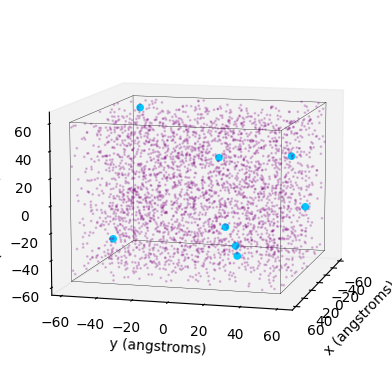

In [379]:
R = FCC_lattice(a, size)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Define custom face and edge colors with different transparency
face_color = (0.5, 0, 0.5, 0.5)  # RGBA for purple with alpha 0.2
edge_color = (0.5, 0, 0.5, 1.0)  # RGBA for purple with full opacity

# ax.scatter(
#     carbon_pts[:, 0], carbon_pts[:, 1], carbon_pts[:, 2],
#     facecolors=face_color,
#     edgecolors=edge_color,
#     marker='o',
#     linewidths=0.5,
#     s=8
# )
# ax.scatter(R[:,0], R[:,1], R[:,2], color='gray', marker='o', alpha = 0.1, s=1)
# ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], facecolors=face_color, edgecolors=edge_color,
#            marker='o',linewidths = 0.5, s=6)
ax.scatter(carbon_pts[:,0], carbon_pts[:,1], carbon_pts[:,2], color = 'purple', marker='o', alpha=0.2, s=1)
ax.scatter(e_pts[:,0], e_pts[:,1], e_pts[:,2], color='#00c8ff', marker='o', alpha = 1, s=20)
ax.grid(False)
# ax.set_box_aspect([1,1,1])  # Equal scaling for x/y/z
ax.set_xlabel('x (angstroms)')
ax.set_ylabel('y (angstroms)')
ax.set_zlabel('z (angstroms)')
# ax.set_xticks([-30, 0, 30])
# ax.set_yticks([-30, 0, 30])
# ax.set_zticks([-30, 0, 30])
from mpl_toolkits.mplot3d import Axes3D  # needed if not already imported

# Light blue background color
bg_color = '#e6e6e6'

ax.xaxis.pane.set_facecolor(bg_color)
ax.yaxis.pane.set_facecolor(bg_color)
ax.zaxis.pane.set_facecolor(bg_color)

# Remove the gray edge lines (optional, but cleaner)
ax.xaxis.pane.set_edgecolor(bg_color)
ax.yaxis.pane.set_edgecolor(bg_color)
ax.zaxis.pane.set_edgecolor(bg_color)

# Get bounding box limits
x_min, x_max = R[:,0].min(), R[:,0].max()
y_min, y_max = R[:,1].min(), R[:,1].max()
z_min, z_max = R[:,2].min(), R[:,2].max()

# Define cube corners
corners = [
    [x_min, y_min, z_min],
    [x_max, y_min, z_min],
    [x_max, y_max, z_min],
    [x_min, y_max, z_min],
    [x_min, y_min, z_max],
    [x_max, y_min, z_max],
    [x_max, y_max, z_max],
    [x_min, y_max, z_max]
]

# Define the 12 edges to connect
edges = [
    (0,1), (1,2), (2,3), (3,0),  # bottom face
    (4,5), (5,6), (6,7), (7,4),  # top face
    (0,4), (1,5), (2,6), (3,7)   # vertical edges
]

# Plot cube edges
for start, end in edges:
    x = [corners[start][0], corners[end][0]]
    y = [corners[start][1], corners[end][1]]
    z = [corners[start][2], corners[end][2]]
    ax.plot(x, y, z, color='black', linewidth=0.25)


ax.view_init(elev=10, azim=15)

plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\Lattice1.svg", transparent=True)
# fig.savefig("C:\\Users\\Suber\\Desktop\\DisorderedElectronNetwork.pdf", format='pdf', dpi=600)

(100, 100)
732.1771726608276


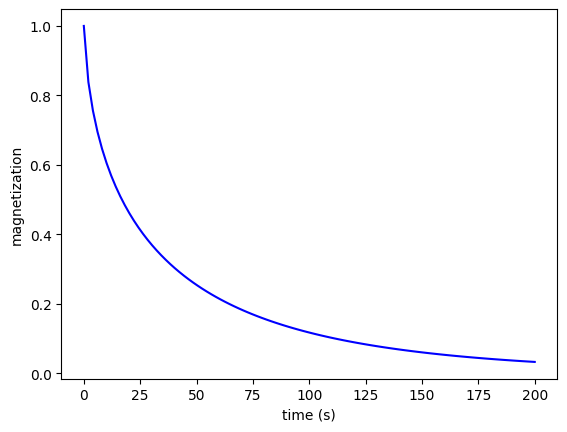

In [4]:
from pathos.multiprocessing import ProcessingPool as Pool
import time 

def run_simulation(params):
    
    import numpy as np
    import random
    from scipy.spatial.distance import cdist
    from scipy.linalg import expm
    from scipy.linalg import logm
    from scipy.linalg import eig, eigh
    from scipy.linalg import null_space
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import expm_multiply
    from scipy.integrate import simps 
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
    #         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    #         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
    #                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)

                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
    #                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M, outside_pts
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha

    T = np.linspace(0,200,100)
    size = 16
    carbon_pts, e_pts = sample_special_positions(3.57, size, 1.1e-2, 30e-6)
    N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)
#     N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 0)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P

start_time = time.time()

iterations = 100
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,200,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

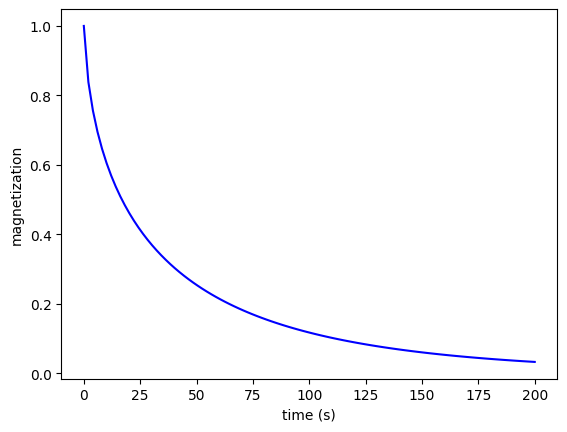

In [5]:
T = np.linspace(0,200,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

np.savez('DisorderedElectronsSize16_Polarization_100Itr.npz', time=T, P_avg=P_avg)

(100, 100)
665.6420056819916


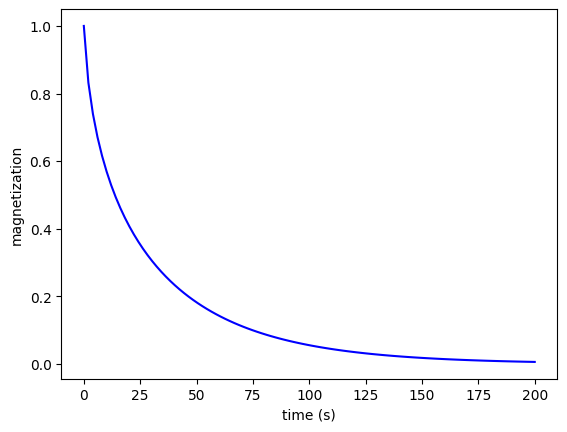

In [6]:
from pathos.multiprocessing import ProcessingPool as Pool
import time 

def run_simulation(params):
    
    import numpy as np
    import random
    from scipy.spatial.distance import cdist
    from scipy.linalg import expm
    from scipy.linalg import logm
    from scipy.linalg import eig, eigh
    from scipy.linalg import null_space
    from scipy.sparse import csr_matrix
    from scipy.sparse.linalg import expm_multiply
    from scipy.integrate import simps 
    
    mu_0 = 1.256e-6 #NA^-2
    hbar = 1.055e-34 #Js
    gamma_C = 10.7084e6 #Hz/T
    gamma_e = 28024.951e6 #Hz/T
    r3 = 16*1e-10 #spin diffusion barrier radius
    
    def sample_special_positions(a, size, prob_C, prob_e):
        # Total number of unit cells
        grid_range = np.arange(-size, size + 1)
        Ncells = len(grid_range) ** 3
        Natoms = Ncells * 8  # 8 atoms per FCC diamond unit cell

        # How many atoms to sample
        num_C = int(Natoms * prob_C)
        num_e = int(Natoms * prob_e)
        total_specials = num_C + num_e

        # Sample linear indices (0 to Natoms-1)
        indices = np.random.choice(Natoms, total_specials, replace=False)
        carbon_indices = np.random.choice(indices, num_C, replace=False)
        electron_indices = np.setdiff1d(indices, carbon_indices, assume_unique=True)

        # Convert linear index to (unit cell index, basis atom index)
        unit_index = indices // 8
        basis_index = indices % 8

        # Map unit index back to (l, m, n) grid coordinates
        n_grid = len(grid_range)
        L = unit_index // (n_grid ** 2)
        M = (unit_index // n_grid) % n_grid
        N = unit_index % n_grid
        L = L + grid_range[0]
        M = M + grid_range[0]
        N = N + grid_range[0]

        # FCC + offset basis
        basis = (a/2)*np.array([
            [0, 0, 0],
            [1, 1, 0],
            [1, 0, 1],
            [0, 1, 1],
            [0.5, 0.5, 0.5],
            [1.5, 1.5, 0.5],
            [1.5, 0.5, 1.5],
            [0.5, 1.5, 1.5],
        ])

        # Construct positions
        unit_coords = np.stack([L, M, N], axis=1) * a
        special_positions = unit_coords + basis[basis_index]

        # Split into carbon and electron positions
        carbon_pts = special_positions[np.isin(indices, carbon_indices)]
        e_pts = special_positions[np.isin(indices, electron_indices)]

        return carbon_pts, e_pts



    def azimuthal_angle(p1, p2):
        diff = p1 - p2
        norm_diff = diff/np.linalg.norm(diff)
        return np.arccos(norm_diff[2])



    def calculate_M(size, carbon_pts, e_pts, tau_p, tau_d):
        diff = carbon_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
        distances = np.linalg.norm(diff, axis=2)
        min_distances = np.min(distances, axis=1)

        inside_pts = carbon_pts[min_distances < r3*1e10]
        outside_pts = carbon_pts[min_distances >= r3*1e10]

        N_carbon = carbon_pts.shape[0]
        N_e = e_pts.shape[0]
        N_bulk = outside_pts.shape[0]
        N_core = inside_pts.shape[0]

        #Calculate R matrix

        #Calculate distances and azimuthal angles between carbon and every electron around it for each carbon 
        #(already similarly done 3 cells above)
    #         diff2 = outside_pts[:, np.newaxis, :] - e_pts[np.newaxis, :, :]
    #         distances2 = np.linalg.norm(diff2, axis=2)

        box_size = 3.57 * (2*size + 1)

        R = np.zeros((N_bulk))
        rates = np.zeros((N_e))
        for carbon in range(N_bulk):
            for e in range(N_e):
    #                 r = distances2[carbon,e]
                diff_r = outside_pts[carbon] - e_pts[e]
                diff_r = diff_r - box_size * np.round(diff_r / box_size)
                r = np.linalg.norm(diff_r)

                unit_vec = diff_r / r
                angle = np.arccos(unit_vec[2])
    #                 angle = azimuthal_angle(outside_pts[carbon], e_pts[e])
                D = 1 - 3*(np.cos(angle))**2 
                C = ((np.pi)*mu_0*gamma_C*gamma_e*hbar*D)/(2*((r*1e-10)**3))
                rates[e] = (1/2)*(C**2)*tau_p
            R[carbon] = np.sum(rates)
            rates = np.zeros((N_e))

        R = np.diag(R)

        #Calculate W matrix
        threshold = 20

        W_PBC = np.zeros((N_bulk, N_bulk))
        for i in range(N_bulk - 1):
            for j in range(i + 1, N_bulk):
                diff = outside_pts[i] - outside_pts[j]
                diff = diff - box_size * np.round(diff / box_size) #Periodic boundary conditions
            #     if not np.allclose(diff, outside_pts[i] - outside_pts[j]):
            #         print("PBC adjusted a distance!")
                dist = np.linalg.norm(diff)
                if dist > threshold:
                        W_PBC[i, j] = 0
                        W_PBC[j, i] = 0  # symmetry
                else:    
                    unit_vec = diff / dist
                    angle = np.arccos(unit_vec[2])

                    A = 1 - 3 * (np.cos(angle))**2
                    B = (np.pi * mu_0 * gamma_C**2 * hbar * A) / (2 * (dist * 1e-10)**3)
                    W_PBC[i, j] = 0.5 * B**2 * tau_d
                    W_PBC[j, i] = 0.5 * B**2 * tau_d  # symmetry

        W_PBC = W_PBC - np.diag(np.sum(W_PBC, axis=0))

        M = W_PBC - R
        return N_bulk, M, outside_pts
    
    def solve_ode(N_bulk, time, alpha_0, M):
        t_pts = len(time)
        alpha = np.zeros((N_bulk, t_pts))

        evals, evecs = eigh(M)
        V_inv = np.linalg.inv(evecs)

        # max_exp = 1000
        # evals_clipped = np.clip(evals, -max_exp, max_exp)

        V_alpha = V_inv @ alpha_0
#         evals = np.diag(M)
        for t in range(t_pts):
            alpha[:, t] = evecs @ (np.exp(evals * time[t]) * V_alpha)
#             alpha[:, t] = np.exp(evals * time[t])

        return alpha

    def get_octant_centers(size, a):

        L = a * (2*size + 1)

        quarter = L / 4
        coords = [-quarter, quarter]
        points = []

        for x in coords:
            for y in coords:
                for z in coords:
                    points.append((x, y, z))

        return np.array(points)

    
    T = np.linspace(0,200,100)
    size = 16
    carbon_pts, _ = sample_special_positions(3.57, size, 1.1e-2, 0)
    e_pts = get_octant_centers(size, 3.57)
    N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 2.5e-5)
#     N_bulk, M, outside_pts = calculate_M(size, carbon_pts, e_pts, 1.75e-8, 0)
    alpha_0 = (1/N_bulk)*np.ones(N_bulk)
    alpha = solve_ode(N_bulk, T, alpha_0, M)
    P = np.sum(alpha, axis=0)
    return P

start_time = time.time()

iterations = 100
inputs = [(1)] * iterations

pool = Pool()
# pool.restart()
results = pool.map(run_simulation, inputs)

print(np.array(results).shape)
end_time = time.time()
print(end_time-start_time)

T = np.linspace(0,200,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

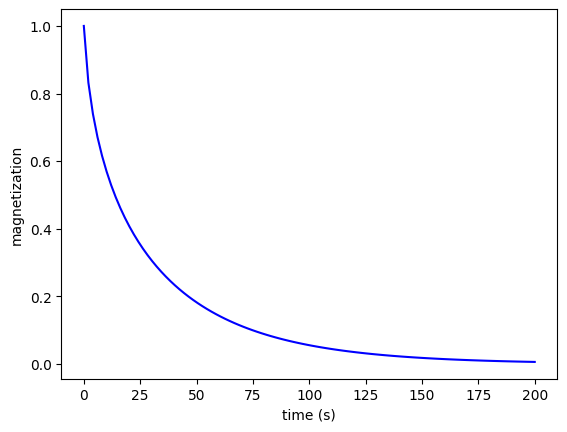

In [7]:
T = np.linspace(0,200,100)
P_avg = (np.sum(np.array(results), axis=0))/iterations
fig = plt.figure()
plt.plot(T, P_avg, color='b')
plt.xlabel('time (s)')
plt.ylabel('magnetization')
plt.show()

np.savez('OrderedElectronsSize16_Polarization_100Itr.npz', time=T, P_avg=P_avg)

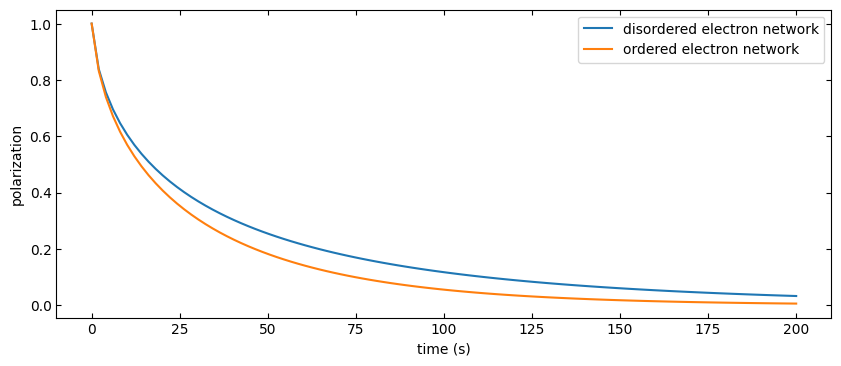

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [9]:
data = np.load('DisorderedElectronsSize16_Polarization_100Itr.npz')
P_disordered = data['P_avg']

data = np.load('OrderedElectronsSize16_Polarization_100Itr.npz')
P_ordered = data['P_avg']

# data = np.load('DisorderedElectronsSize16_Polarization_W=0.npz')
# P_disordered_MA = data['P_avg']

# data = np.load('OrderedElectronsSize16_Polarization_W=0.npz')
# P_ordered_MA = data['P_avg']

T = np.linspace(0,200,100)
fig = plt.figure(figsize=(10, 4))
plt.plot(T, P_disordered, label='disordered electron network')
plt.plot(T, P_ordered, label='ordered electron network')
# plt.plot(T, P_disordered_MA, label='disordered electron network W=0')
# plt.plot(T, P_ordered_MA, label='ordered electron network W=0')
plt.tick_params(direction='in')  # for both x and y
plt.tick_params(top=True, right=True)
plt.xlabel('time (s)')
plt.ylabel('polarization')
plt.legend()
plt.show()

# fig.savefig("C:\\Users\\Suber\\Desktop\\OrderedVsDisorderedPolarization_v2.eps", format='eps', dpi=300)